In [1]:
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer


from sklearn.feature_extraction.text import CountVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sentence_transformers import SentenceTransformer


import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import numpy as np

c:\Users\Liza\anaconda3\envs\KPLiza\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import json
from sklearn.feature_extraction.text import CountVectorizer
 
texts = []
with open(r"C:\Users\Liza\Documents\emilia\scoring\data_7500.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        q = data.get("question", "")
        a = data.get("answer", "")
        texts.append(f"Q: {q} A: {a}")

#  Lowercase all text 
texts_lower = [text.lower() for text in texts]

#  Stemming dengan Sastrawi 
stemmer = StemmerFactory().create_stemmer()
stemmed_texts = [stemmer.stem(text) for text in texts_lower]

#  Stopword removal 
stop_factory = StopWordRemoverFactory()
stopwords_indonesia = stop_factory.get_stop_words()

def remove_stopwords(text, stopwords):
    return " ".join([word for word in text.split() if word not in stopwords])

final_clean_texts = [remove_stopwords(text, stopwords_indonesia) for text in stemmed_texts]

for i in range(10):
    print(f"\nTeks Before:\n{texts[i]}")
    print(f"Teks After:\n{final_clean_texts[i]}")



Teks Before:
Q: Bagaimana cara berhenti menyalahkan diri sendiri atas semua hal? A: Mulailah memetakan fakta: apa yang benar-benar di bawah kendalimu dan apa yang tidak. Tanggung jawab realistis membuatmu bisa berkata, "Ini porsiku, sisanya bukan," lalu lepaskan beban ekstra itu. Setelah itu beri dirimu afirmasi bahwa manusia wajar berbuat salah. Pendekatan ini sejalan dengan konsep self-compassion dari Kristin Neff.
Teks After:
q bagaimana cara henti salah diri sendiri atas semua a mulai meta fakta apa benar bawah kendali apa tanggung jawab realistis buat kata porsi sisa bukan lalu lepas beban ekstra beri diri afirmasi manusia wajar buat salah dekat jalan konsep self-compassion kristin neff

Teks Before:
Q: Kenapa, ya, aku jadi menjauh dari teman setelah melakukan kesalahan? A: Perasaan bersalah yang belum diproses menimbulkan kecemasan setiap kali bertemu mereka, sehingga otakmu memilih menghindar demi rasa aman semu. Akui kesalahanmu secara terbuka, sampaikan maaf yang tulus, lalu 

In [4]:
# ------- Fungsi Evaluasi --------
def topic_words_from_model(topic_model, top_n=10):
    """Kembalikan dict: topic_id -> list[kata]"""
    topic_words = {}
    for topic_id in topic_model.get_topic_info().Topic:
        if topic_id == -1:
            continue
        words = [w for w, _ in topic_model.get_topic(topic_id)[:top_n]]
        topic_words[topic_id] = words
    return topic_words

def compute_topic_diversity(topic_words_dict):
    """Proporsi kata unik / total kata (semakin tinggi semakin beragam)."""
    all_words = [w for words in topic_words_dict.values() for w in words]
    if not all_words:
        return 0.0
    unique = len(set(all_words))
    total = len(all_words)
    return unique / total

def compute_coherence_cv(topic_model, docs_tokenized, topic_words_dict):
    """Hitung coherence C_v pakai gensim"""
    if not topic_words_dict:
        return 0.0
    dictionary = Dictionary(docs_tokenized)
    corpus = [dictionary.doc2bow(tokens) for tokens in docs_tokenized]
    topics = list(topic_words_dict.values())
    cm = CoherenceModel(
        topics=topics,
        texts=docs_tokenized,
        dictionary=dictionary,
        corpus=corpus,
        coherence='c_v'
    )
    return cm.get_coherence()


In [ ]:
# Model embedding

embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2") 
# embedding_model = SentenceTransformer("all-MiniLM-L6-v2") 
# embedding_model = SentenceTransformer("cahya/bert-base-indonesian-522M")  
# embedding_model = SentenceTransformer("asaduas/all-MiniLM-L6-v2-indonesia-squadv2")

# model_name='cahya/bert-base-indonesian-522M'
# tokenizer = BertTokenizer.from_pretrained(model_name)

In [27]:
# UMAP, Vectorizer, C-TF-IDF, Representation
umap_model = UMAP(
    n_neighbors=min(15, len(final_clean_texts)-1),  
    n_components=min(5, len(final_clean_texts)-1),
    min_dist=0.0,
    metric='cosine',
    random_state=45
)

vectorizer_model = CountVectorizer(stop_words=stopwords_indonesia)
ctfidf_model = ClassTfidfTransformer()
representation_model = KeyBERTInspired()


In [ ]:
## Percobaan pertama
from hdbscan import HDBSCAN

# min_cluster_size yang diuji
cluster_sizes = [10, 15, 20, 30, 50]
all_results = []

for size in cluster_sizes:
    print(f"\n=== Evaluasi untuk min_cluster_size={size} ===")

    # HDBSCAN 
    hdbscan_model = HDBSCAN(
        min_cluster_size=size,
        metric='euclidean',
        prediction_data=True,
        cluster_selection_method='eom'
    )

    # Pipeline BERTopic 
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        ctfidf_model=ctfidf_model,
        representation_model=representation_model,
        language="indonesian"  
    )

    # Fit-transform
    topics, probs = topic_model.fit_transform(final_clean_texts)

    # Tokenized docs
    docs_tokenized = [doc.split() for doc in final_clean_texts]

    # Ambil kata topik
    topic_words = topic_words_from_model(topic_model, top_n=10)

    # Evaluasi
    diversity = compute_topic_diversity(topic_words)
    coherence_cv = compute_coherence_cv(topic_model, docs_tokenized, topic_words)

    # Info 
    info = topic_model.get_topic_info()
    n_topics = len(info[info.Topic != -1])
    n_outliers = int(info[info.Topic == -1].Count.values[0]) if -1 in info.Topic.values else 0

    print("Jumlah Topik:", n_topics)
    print("Outliers:", n_outliers)
    print("Coherence C_v:", round(coherence_cv, 4))
    print("Diversity:", round(diversity, 4))

    all_results.append({
        "min_cluster_size": size,
        "Jumlah_Topik": n_topics,
        "Outliers": n_outliers,
        "Coherence_Cv": round(coherence_cv, 4),
        "Diversity": round(diversity, 4)
    })

    df_docs = topic_model.get_document_info(final_clean_texts)
    df_docs.to_csv(f"Result7500_L12_Cluster{size}.csv", index=False)


print("\n=== Semua hasil tersimpan ke CSV ===")



=== Evaluasi untuk min_cluster_size=10 ===
Jumlah Topik: 123
Outliers: 2428
Coherence C_v: 0.3551
Diversity: 0.3073

=== Evaluasi untuk min_cluster_size=15 ===
Jumlah Topik: 92
Outliers: 2695
Coherence C_v: 0.361
Diversity: 0.3304

=== Evaluasi untuk min_cluster_size=20 ===
Jumlah Topik: 66
Outliers: 2564
Coherence C_v: 0.3668
Diversity: 0.3515

=== Evaluasi untuk min_cluster_size=30 ===
Jumlah Topik: 46
Outliers: 2773
Coherence C_v: 0.3797
Diversity: 0.3935

=== Evaluasi untuk min_cluster_size=50 ===
Jumlah Topik: 26
Outliers: 2868
Coherence C_v: 0.377
Diversity: 0.4385

=== Semua hasil tersimpan ke CSV ===


In [10]:
## Percobaan kedua
from hdbscan import HDBSCAN

# min_cluster_size yang diuji
cluster_sizes = [21, 22, 23, 24, 25]
all_results = []

for size in cluster_sizes:
    print(f"\n=== Evaluasi untuk min_cluster_size={size} ===")

    # HDBSCAN 
    hdbscan_model = HDBSCAN(
        min_cluster_size=size,
        metric='euclidean',
        prediction_data=True,
        cluster_selection_method='eom'
    )

    # Pipeline BERTopic 
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        ctfidf_model=ctfidf_model,
        representation_model=representation_model,
        language="indonesian"  
    )

    # Fit-transform
    topics, probs = topic_model.fit_transform(final_clean_texts)

    # Tokenized docs
    docs_tokenized = [doc.split() for doc in final_clean_texts]

    # Ambil kata topik
    topic_words = topic_words_from_model(topic_model, top_n=10)

    # Evaluasi
    diversity = compute_topic_diversity(topic_words)
    coherence_cv = compute_coherence_cv(topic_model, docs_tokenized, topic_words)

    # Info 
    info = topic_model.get_topic_info()
    n_topics = len(info[info.Topic != -1])
    n_outliers = int(info[info.Topic == -1].Count.values[0]) if -1 in info.Topic.values else 0

    print("Jumlah Topik:", n_topics)
    print("Outliers:", n_outliers)
    print("Coherence C_v:", round(coherence_cv, 4))
    print("Diversity:", round(diversity, 4))

    all_results.append({
        "min_cluster_size": size,
        "Jumlah_Topik": n_topics,
        "Outliers": n_outliers,
        "Coherence_Cv": round(coherence_cv, 4),
        "Diversity": round(diversity, 4)
    })

    df_docs = topic_model.get_document_info(final_clean_texts)
    df_docs.to_csv(f"Result7500_L12_Cluster{size}.csv", index=False)


print("\n=== Semua hasil tersimpan ke CSV ===")



=== Evaluasi untuk min_cluster_size=21 ===
Jumlah Topik: 60
Outliers: 2446
Coherence C_v: 0.3776
Diversity: 0.34

=== Evaluasi untuk min_cluster_size=22 ===
Jumlah Topik: 59
Outliers: 2470
Coherence C_v: 0.376
Diversity: 0.3458

=== Evaluasi untuk min_cluster_size=23 ===
Jumlah Topik: 59
Outliers: 2697
Coherence C_v: 0.3739
Diversity: 0.3441

=== Evaluasi untuk min_cluster_size=24 ===
Jumlah Topik: 60
Outliers: 2860
Coherence C_v: 0.3746
Diversity: 0.36

=== Evaluasi untuk min_cluster_size=25 ===
Jumlah Topik: 55
Outliers: 2454
Coherence C_v: 0.38
Diversity: 0.3691

=== Semua hasil tersimpan ke CSV ===


yang dipake 
```
=== Evaluasi untuk min_cluster_size=25 ===
Jumlah Topik: 55
Outliers: 2454
Coherence C_v: 0.38
Diversity: 0.3691
```

## Nanganin outlier 05/10

In [ ]:
  ## Percobaan kedua
from hdbscan import HDBSCAN

# min_cluster_size yang diuji
cluster_sizes = [21, 22, 23, 24, 25]
all_results = []

for size in cluster_sizes:
    print(f"\n=== Evaluasi untuk min_cluster_size={size} ===")

    # HDBSCAN 
    hdbscan_model = HDBSCAN(
        min_cluster_size=size,
        min_samples=5,
        metric='euclidean',
        prediction_data=True,
        cluster_selection_method='eom'
    )

    # Pipeline BERTopic 
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        ctfidf_model=ctfidf_model,
        representation_model=representation_model,
        language="indonesian"  
    )

    # Fit-transform
    topics, probs = topic_model.fit_transform(final_clean_texts)

    # Tokenized docs
    docs_tokenized = [doc.split() for doc in final_clean_texts]

    topic_words = topic_words_from_model(topic_model, top_n=10)

    # Evaluasi
    diversity = compute_topic_diversity(topic_words)
    coherence_cv = compute_coherence_cv(topic_model, docs_tokenized, topic_words)

    info = topic_model.get_topic_info()
    n_topics = len(info[info.Topic != -1])
    n_outliers = int(info[info.Topic == -1].Count.values[0]) if -1 in info.Topic.values else 0

    print("Jumlah Topik:", n_topics)
    print("Outliers:", n_outliers)
    print("Coherence C_v:", round(coherence_cv, 4))
    print("Diversity:", round(diversity, 4))

    all_results.append({
        "min_cluster_size": size,
        "Jumlah_Topik": n_topics,
        "Outliers": n_outliers,
        "Coherence_Cv": round(coherence_cv, 4),
        "Diversity": round(diversity, 4)
    })

    df_docs = topic_model.get_document_info(final_clean_texts)
    df_docs.to_csv(f"Result7500_L12_Cluster{size}.csv", index=False)


print("\n=== Semua hasil tersimpan ke CSV ===")



=== Evaluasi untuk min_cluster_size=21 ===
Jumlah Topik: 78
Outliers: 1974
Coherence C_v: 0.3794
Diversity: 0.3423

=== Evaluasi untuk min_cluster_size=22 ===
Jumlah Topik: 77
Outliers: 1995
Coherence C_v: 0.3708
Diversity: 0.3416

=== Evaluasi untuk min_cluster_size=23 ===
Jumlah Topik: 74
Outliers: 1942
Coherence C_v: 0.3769
Diversity: 0.3392

=== Evaluasi untuk min_cluster_size=24 ===
Jumlah Topik: 73
Outliers: 1965
Coherence C_v: 0.3775
Diversity: 0.3397

=== Evaluasi untuk min_cluster_size=25 ===
Jumlah Topik: 70
Outliers: 1871
Coherence C_v: 0.3721
Diversity: 0.3329

=== Semua hasil tersimpan ke CSV ===


Best result
```
=== Evaluasi untuk min_cluster_size=25 ===
Jumlah Topik: 70
Outliers: 1871
Coherence C_v: 0.3721
Diversity: 0.3329
```

## Hyperparameter Tuning

In [ ]:
import optuna
import pandas as pd
from bertopic import BERTopic
from hdbscan import HDBSCAN
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer

trial_results = []

def objective(trial):
    
    n_neighbors = trial.suggest_int("n_neighbors", 5, 25)
    n_components = trial.suggest_int("n_components", 2, 8)
    min_dist = trial.suggest_float("min_dist", 0.0, 0.3)
    min_cluster_size = trial.suggest_int("min_cluster_size", 15, 30)
    min_samples = trial.suggest_int("min_samples", 1, 10)   


    umap_model = UMAP(
        n_neighbors=min(n_neighbors, len(final_clean_texts)-1),
        n_components=min(n_components, len(final_clean_texts)-1),
        min_dist=min_dist,
        metric='cosine',
        random_state=42
    )

  
    hdbscan_model = HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean',
        prediction_data=True,
        cluster_selection_method='eom'
    )

   
    vectorizer_model = CountVectorizer(stop_words=stopwords_indonesia)
    ctfidf_model = ClassTfidfTransformer()
    representation_model = KeyBERTInspired()

    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        ctfidf_model=ctfidf_model,
        representation_model=representation_model,
        language="indonesian"
    )

 
    topics, probs = topic_model.fit_transform(final_clean_texts)
    docs_tokenized = [doc.split() for doc in final_clean_texts]
    topic_words = topic_words_from_model(topic_model, top_n=10)

    coherence_cv = compute_coherence_cv(topic_model, docs_tokenized, topic_words)
    diversity = compute_topic_diversity(topic_words)

    info = topic_model.get_topic_info()
    n_topics = len(info[info.Topic != -1])
    n_outliers = int(info[info.Topic == -1].Count.values[0]) if -1 in info.Topic.values else 0

  
    trial_results.append({
        "Trial": trial.number,
        "n_neighbors": n_neighbors,
        "n_components": n_components,
        "min_dist": min_dist,
        "min_cluster_size": min_cluster_size,
        "min_samples": min_samples,
        "Jumlah_Topik": n_topics,
        "Outliers": n_outliers,
        "Coherence_Cv": round(coherence_cv, 4),
        "Diversity": round(diversity, 4),
        "Score": round((0.7 * coherence_cv + 0.3 * diversity), 4)
    })

    print(f"[Trial {trial.number}] Topics={n_topics}, Outliers={n_outliers}, "
          f"Coherence={coherence_cv:.4f}, Diversity={diversity:.4f}")

    return 0.7 * coherence_cv + 0.3 * diversity



study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)


df_trials = pd.DataFrame(trial_results).sort_values(by="Score", ascending=False)
df_trials.to_csv("BERTopic_Optuna_Tuning_Results.csv", index=False)

print("\n=== Hasil Terbaik ===")
print(df_trials.head(5))
print("\nBest Parameters:", study.best_params)
print("Best Score:", study.best_value)


[I 2025-10-29 06:00:57,806] A new study created in memory with name: no-name-bd127441-ef18-496c-9649-09d58f995fe1
[I 2025-10-29 06:04:41,665] Trial 0 finished with value: 0.33947717808065725 and parameters: {'n_neighbors': 15, 'n_components': 8, 'min_dist': 0.07348545813342935, 'min_cluster_size': 17, 'min_samples': 1}. Best is trial 0 with value: 0.33947717808065725.


[Trial 0] Topics=109, Outliers=2103, Coherence=0.3603, Diversity=0.2908


[I 2025-10-29 06:07:39,626] Trial 1 finished with value: 0.3691462731756747 and parameters: {'n_neighbors': 14, 'n_components': 3, 'min_dist': 0.15989159475593304, 'min_cluster_size': 25, 'min_samples': 3}. Best is trial 1 with value: 0.3691462731756747.


[Trial 1] Topics=65, Outliers=1930, Coherence=0.3823, Diversity=0.3385


[I 2025-10-29 06:10:34,168] Trial 2 finished with value: 0.3716504725659294 and parameters: {'n_neighbors': 12, 'n_components': 6, 'min_dist': 0.19852354376375483, 'min_cluster_size': 20, 'min_samples': 6}. Best is trial 2 with value: 0.3716504725659294.


[Trial 2] Topics=68, Outliers=3178, Coherence=0.3860, Diversity=0.3382


[I 2025-10-29 06:13:33,755] Trial 3 finished with value: 0.35961174668007045 and parameters: {'n_neighbors': 15, 'n_components': 7, 'min_dist': 0.2244603701624922, 'min_cluster_size': 20, 'min_samples': 4}. Best is trial 2 with value: 0.3716504725659294.


[Trial 3] Topics=69, Outliers=3059, Coherence=0.3684, Diversity=0.3391


[I 2025-10-29 06:16:35,555] Trial 4 finished with value: 0.35257120726269453 and parameters: {'n_neighbors': 24, 'n_components': 2, 'min_dist': 0.20283925996105204, 'min_cluster_size': 29, 'min_samples': 4}. Best is trial 2 with value: 0.3716504725659294.


[Trial 4] Topics=73, Outliers=2200, Coherence=0.3716, Diversity=0.3082


[I 2025-10-29 06:19:31,856] Trial 5 finished with value: 0.3721375053174637 and parameters: {'n_neighbors': 8, 'n_components': 5, 'min_dist': 0.25041688151794783, 'min_cluster_size': 27, 'min_samples': 10}. Best is trial 5 with value: 0.3721375053174637.


[Trial 5] Topics=46, Outliers=3056, Coherence=0.3695, Diversity=0.3783


[I 2025-10-29 06:22:26,749] Trial 6 finished with value: 0.38647779200651244 and parameters: {'n_neighbors': 11, 'n_components': 8, 'min_dist': 0.17642388424888342, 'min_cluster_size': 27, 'min_samples': 5}. Best is trial 6 with value: 0.38647779200651244.


[Trial 6] Topics=54, Outliers=2659, Coherence=0.3831, Diversity=0.3944


[I 2025-10-29 06:25:20,656] Trial 7 finished with value: 0.35206670683181585 and parameters: {'n_neighbors': 8, 'n_components': 6, 'min_dist': 0.18830898711273222, 'min_cluster_size': 21, 'min_samples': 6}. Best is trial 6 with value: 0.38647779200651244.


[Trial 7] Topics=70, Outliers=2598, Coherence=0.3658, Diversity=0.3200


[I 2025-10-29 06:28:15,166] Trial 8 finished with value: 0.39148490144588083 and parameters: {'n_neighbors': 11, 'n_components': 6, 'min_dist': 0.17529880398384404, 'min_cluster_size': 28, 'min_samples': 7}. Best is trial 8 with value: 0.39148490144588083.


[Trial 8] Topics=50, Outliers=2666, Coherence=0.4015, Diversity=0.3680


[I 2025-10-29 06:31:38,755] Trial 9 finished with value: 0.3499924834914495 and parameters: {'n_neighbors': 14, 'n_components': 4, 'min_dist': 0.1534042958054172, 'min_cluster_size': 22, 'min_samples': 3}. Best is trial 8 with value: 0.39148490144588083.


[Trial 9] Topics=82, Outliers=2659, Coherence=0.3604, Diversity=0.3256


[I 2025-10-29 06:34:58,731] Trial 10 finished with value: 0.3680097665187061 and parameters: {'n_neighbors': 24, 'n_components': 5, 'min_dist': 0.007691518503030043, 'min_cluster_size': 30, 'min_samples': 9}. Best is trial 8 with value: 0.39148490144588083.


[Trial 10] Topics=50, Outliers=2501, Coherence=0.3663, Diversity=0.3720


[I 2025-10-29 06:37:49,817] Trial 11 finished with value: 0.36012643684892165 and parameters: {'n_neighbors': 5, 'n_components': 8, 'min_dist': 0.10408927463071463, 'min_cluster_size': 25, 'min_samples': 8}. Best is trial 8 with value: 0.39148490144588083.


[Trial 11] Topics=67, Outliers=2082, Coherence=0.3757, Diversity=0.3239


[I 2025-10-29 06:40:47,403] Trial 12 finished with value: 0.386175828943079 and parameters: {'n_neighbors': 19, 'n_components': 7, 'min_dist': 0.29064189885678404, 'min_cluster_size': 27, 'min_samples': 7}. Best is trial 8 with value: 0.39148490144588083.


[Trial 12] Topics=45, Outliers=3350, Coherence=0.3679, Diversity=0.4289


[I 2025-10-29 06:43:41,073] Trial 13 finished with value: 0.35754885051885477 and parameters: {'n_neighbors': 10, 'n_components': 7, 'min_dist': 0.10510847686016346, 'min_cluster_size': 26, 'min_samples': 5}. Best is trial 8 with value: 0.39148490144588083.


[Trial 13] Topics=60, Outliers=2244, Coherence=0.3694, Diversity=0.3300


[I 2025-10-29 06:46:36,626] Trial 14 finished with value: 0.3761760828238428 and parameters: {'n_neighbors': 19, 'n_components': 6, 'min_dist': 0.11859481821387495, 'min_cluster_size': 29, 'min_samples': 8}. Best is trial 8 with value: 0.39148490144588083.


[Trial 14] Topics=49, Outliers=2899, Coherence=0.3747, Diversity=0.3796


[I 2025-10-29 06:49:32,741] Trial 15 finished with value: 0.36486943613257755 and parameters: {'n_neighbors': 18, 'n_components': 8, 'min_dist': 0.2645683002460336, 'min_cluster_size': 24, 'min_samples': 7}. Best is trial 8 with value: 0.39148490144588083.


[Trial 15] Topics=51, Outliers=3342, Coherence=0.3767, Diversity=0.3373


[I 2025-10-29 06:52:26,988] Trial 16 finished with value: 0.3347687075106635 and parameters: {'n_neighbors': 11, 'n_components': 4, 'min_dist': 0.043521957577492526, 'min_cluster_size': 15, 'min_samples': 5}. Best is trial 8 with value: 0.39148490144588083.


[Trial 16] Topics=119, Outliers=1983, Coherence=0.3580, Diversity=0.2807


[I 2025-10-29 06:55:17,718] Trial 17 finished with value: 0.3589834334459044 and parameters: {'n_neighbors': 6, 'n_components': 7, 'min_dist': 0.1655945470232248, 'min_cluster_size': 28, 'min_samples': 2}. Best is trial 8 with value: 0.39148490144588083.


[Trial 17] Topics=72, Outliers=1973, Coherence=0.3819, Diversity=0.3056


[I 2025-10-29 06:58:09,952] Trial 18 finished with value: 0.3655450198140838 and parameters: {'n_neighbors': 9, 'n_components': 5, 'min_dist': 0.13061553104867052, 'min_cluster_size': 23, 'min_samples': 7}. Best is trial 8 with value: 0.39148490144588083.


[Trial 18] Topics=67, Outliers=2342, Coherence=0.3751, Diversity=0.3433


[I 2025-10-29 07:01:04,559] Trial 19 finished with value: 0.38209842529063587 and parameters: {'n_neighbors': 12, 'n_components': 8, 'min_dist': 0.21827599335141754, 'min_cluster_size': 30, 'min_samples': 10}. Best is trial 8 with value: 0.39148490144588083.


[Trial 19] Topics=44, Outliers=3164, Coherence=0.3744, Diversity=0.4000

=== Hasil Terbaik ===
    Trial  n_neighbors  n_components  min_dist  min_cluster_size  min_samples  \
8       8           11             6  0.175299                28            7   
6       6           11             8  0.176424                27            5   
12     12           19             7  0.290642                27            7   
19     19           12             8  0.218276                30           10   
14     14           19             6  0.118595                29            8   

    Jumlah_Topik  Outliers  Coherence_Cv  Diversity   Score  
8             50      2666        0.4015     0.3680  0.3915  
6             54      2659        0.3831     0.3944  0.3865  
12            45      3350        0.3679     0.4289  0.3862  
19            44      3164        0.3744     0.4000  0.3821  
14            49      2899        0.3747     0.3796  0.3762  

Best Parameters: {'n_neighbors': 11, 'n_compo

## Nyatuin QA dan hasil topik

In [ ]:
# Nyatuin QA dan hasil topik
import pandas as pd
import json
import csv

df_topic = pd.read_csv("Result7500_L12_Cluster25.csv")

# Baca QA dari JSONL
qa_list = []
with open(r"C:\Users\Liza\Documents\emilia\scoring\data_7500.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        qa_list.append({
            "question": data["question"],
            "answer": data["answer"]
        })

df_qa = pd.DataFrame(qa_list)

assert len(df_topic) == len(df_qa), "Jumlah row CSV dan JSONL tidak sama!"

df_merged = pd.concat([df_qa, df_topic], axis=1)

df_merged.to_csv(
    "new_KPL12_25_7500_70.csv",
    index=False,
    sep=";",                
    encoding="utf-8-sig",
    quoting=csv.QUOTE_ALL   
)

print("Selesai!")


Selesai!


## Misahin outlier

In [12]:
import pandas as pd

df_topics = pd.read_csv("new_KPL12_25_7500_QA.csv", sep=";")
df_topics


,question,answer,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Bagaimana cara berhenti menyalahkan diri sendi...,Mulailah memetakan fakta: apa yang benar-benar...,q bagaimana cara henti salah diri sendiri atas...,-1,-1_psikolog_ubah_diri_tenang,"['psikolog', 'ubah', 'diri', 'tenang', 'biar',...",['q aku ngerasa dunia adil semua orang cuma mi...,psikolog - ubah - diri - tenang - biar - bilan...,0.000000,False
1,"Kenapa, ya, aku jadi menjauh dari teman setela...",Perasaan bersalah yang belum diproses menimbul...,q aku jadi jauh teman laku salah a asa salah p...,-1,-1_psikolog_ubah_diri_tenang,"['psikolog', 'ubah', 'diri', 'tenang', 'biar',...",['q aku ngerasa dunia adil semua orang cuma mi...,psikolog - ubah - diri - tenang - biar - bilan...,0.000000,False
2,Seperti apa contoh permintaan maaf yang efektif?,"Pertama, rangkum inti peristiwa: ""Aku sadar ke...",q apa contoh minta maaf efektif a pertama rang...,-1,-1_psikolog_ubah_diri_tenang,"['psikolog', 'ubah', 'diri', 'tenang', 'biar',...",['q aku ngerasa dunia adil semua orang cuma mi...,psikolog - ubah - diri - tenang - biar - bilan...,0.000000,False
3,Kenapa aku perlu memaafkan diriku sebelum oran...,Self-forgiveness memutus siklus rasa bersalah ...,q aku perlu maaf diri orang a self-forgiveness...,50,50_suportif_minta_gimana_ngerasa,"['suportif', 'minta', 'gimana', 'ngerasa', 'bu...",['q aku rasa salah banget atas udah jadi giman...,suportif - minta - gimana - ngerasa - buat - t...,1.000000,False
4,Langkah pertama menata ulang hidup setelah kes...,"Mulailah dari hal simpel: tidur cukup, rutinit...",q langkah pertama tata ulang hidup salah apa a...,5,5_latih_susah_sulit_jangka,"['latih', 'susah', 'sulit', 'jangka', 'distrak...",['q aku sering ngerasa otak penuh kalau ajar b...,latih - susah - sulit - jangka - distraksi - t...,0.868044,False
...,...,...,...,...,...,...,...,...,...,...
7495,Aku kesal banget sama rekan kerja yang selalu ...,"Kesal itu wajar, tapi kasih pelajaran langsung...",q aku kesal banget sama rekan kerja selalu amb...,4,4_frustrasi_skill_feedback_stres,"['frustrasi', 'skill', 'feedback', 'stres', 'l...",['q aku sering ngerasa tempat kerja apa aku la...,frustrasi - skill - feedback - stres - laku - ...,0.574905,False
7496,Aku merasa nggak cukup baik dibandingkan orang...,"Perasaan itu sering datang, tapi coba ingat: k...",q aku rasa cukup baik banding orang gimana car...,3,3_ekspektasi_sifat_laku_hasil,"['ekspektasi', 'sifat', 'laku', 'hasil', 'usah...",['q emilia aku rasa cukup baik banding orang g...,ekspektasi - sifat - laku - hasil - usaha - eg...,0.892336,False
7497,Aku pengen ngeluh terus kalau kerjaan nggak ad...,"Ngeluh sesekali boleh, tapi kalau terus-terusa...",q aku ken ngeluh terus kalau kerja adil wajar ...,4,4_frustrasi_skill_feedback_stres,"['frustrasi', 'skill', 'feedback', 'stres', 'l...",['q aku sering ngerasa tempat kerja apa aku la...,frustrasi - skill - feedback - stres - laku - ...,0.840464,False
7498,Aku merasa orang lain nggak pantas dapat posis...,"Wajar kalau merasa kecewa, tapi fokus ke orang...",q aku rasa orang pantas posisi lebih tinggi ak...,3,3_ekspektasi_sifat_laku_hasil,"['ekspektasi', 'sifat', 'laku', 'hasil', 'usah...",['q emilia aku rasa cukup baik banding orang g...,ekspektasi - sifat - laku - hasil - usaha - eg...,0.942664,False


In [16]:
import csv
if df_topics["Representative_document"].dtype == object:
    df_topics["Representative_document"] = df_topics["Representative_document"].map(
        {"True": True, "False": False}
    )

filtered = df_topics[df_topics["Topic"] == -1]

filtered
filtered.to_csv("fix/KP_data_outlierQA.csv", index=False, sep=";", encoding="utf-8-sig", quoting=csv.QUOTE_ALL)

## Clustering 

In [49]:
import pandas as pd
import ast
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster

# 1. Load data
df = pd.read_csv("KP_tanpaoutlier.csv", sep=";")
df = df[df["Topic"] != -1]

# 2. Parse representation
df["rep_list"] = df["Representation"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
df["rep_clean"] = df["rep_list"].apply(lambda x: " ".join(x))

# 3. Embedding
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
embeddings = model.encode(df["rep_clean"].tolist(), show_progress_bar=True)


print("=== sklearn AgglomerativeClustering ===")
for t in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    cluster_model = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=t,
        metric="cosine",     
        linkage="average"    
    )
    labels = cluster_model.fit_predict(embeddings)
    print(f"Threshold {t} → {len(set(labels))} cluster")


print("\n=== scipy fcluster ===")
Z = linkage(embeddings, method="average", metric="cosine")

for t in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    clusters = fcluster(Z, t=t, criterion="distance")
    print(f"Threshold {t} → {len(set(clusters))} cluster")




Batches: 100%|██████████| 158/158 [00:22<00:00,  7.09it/s]


=== sklearn AgglomerativeClustering ===
Threshold 0.2 → 42 cluster
Threshold 0.3 → 24 cluster
Threshold 0.4 → 11 cluster
Threshold 0.5 → 4 cluster
Threshold 0.6 → 2 cluster
Threshold 0.7 → 1 cluster

=== scipy fcluster ===
Threshold 0.2 → 42 cluster
Threshold 0.3 → 24 cluster
Threshold 0.4 → 11 cluster
Threshold 0.5 → 4 cluster
Threshold 0.6 → 2 cluster
Threshold 0.7 → 1 cluster


In [53]:
final_threshold = 0.4
clusters = fcluster(Z, t=final_threshold, criterion="distance")
df["merged_cluster"] = clusters

df.to_csv("clustered4.csv", sep=";", index=False, encoding="utf-8-sig")
df

,question,answer,Topic,Representation,rep_list,rep_clean,merged_cluster
0,"Aku suka minum alkohol biar rileks, apa itu ar...",Minum alkohol untuk rileks nggak langsung bera...,7,"['mental', 'laku', 'situasi', 'kadang', 'bilan...","[mental, laku, situasi, kadang, bilang, stres,...",mental laku situasi kadang bilang stres tenang...,9
1,Saya merasa bersalah karena sering marah ke an...,"Hai, rasa bersalah itu tanda kamu peduli bange...",19,"['mindset', 'sifat', 'pengaruh', 'sendiri', 'p...","[mindset, sifat, pengaruh, sendiri, percaya, k...",mindset sifat pengaruh sendiri percaya kadang ...,6
2,Aku merasa otakku lelet buat mengingat pelajar...,"Belajar itu memang kadang terasa berat, tapi k...",5,"['latih', 'susah', 'sulit', 'jangka', 'distrak...","[latih, susah, sulit, jangka, distraksi, tenan...",latih susah sulit jangka distraksi tenang laku...,9
3,Aku takut psikolog nggak ngerti budayaku. Apa ...,Aku ngerti kamu pengen dipahami sesuai budayam...,22,"['psychological', 'psikolog', 'kompetensi', 'l...","[psychological, psikolog, kompetensi, latih, k...",psychological psikolog kompetensi latih khawat...,8
4,"Saya sering bermimpi, tapi tidak tahu artinya....",Mimpi itu seperti petunjuk dari batinmu—seru b...,44,"['emosi', 'bilang', 'tenang', 'tulis', 'kadang...","[emosi, bilang, tenang, tulis, kadang, diri, k...",emosi bilang tenang tulis kadang diri kamu kal...,11
...,...,...,...,...,...,...,...
5041,Aku merasa nggak ada yang peduli sama orang-or...,"Aku tahu rasanya bisa terasa begitu, tapi sebe...",15,"['saran', 'mental', 'sosial', 'muda', 'soal', ...","[saran, mental, sosial, muda, soal, konselor, ...",saran mental sosial muda soal konselor bantu k...,4
5042,"Emilia, kenapa ya layanan buat orang dengan ga...","Sayangnya, banyak layanan memang menghadapi ta...",15,"['saran', 'mental', 'sosial', 'muda', 'soal', ...","[saran, mental, sosial, muda, soal, konselor, ...",saran mental sosial muda soal konselor bantu k...,4
5043,Aku dengar tentang community mental health cen...,Community mental health centers itu pusat laya...,15,"['saran', 'mental', 'sosial', 'muda', 'soal', ...","[saran, mental, sosial, muda, soal, konselor, ...",saran mental sosial muda soal konselor bantu k...,4
5044,"Emilia, aku merasa sistem pelayanan kesehatan ...","Aku paham, rasanya frustrasi kalau layanan ngg...",15,"['saran', 'mental', 'sosial', 'muda', 'soal', ...","[saran, mental, sosial, muda, soal, konselor, ...",saran mental sosial muda soal konselor bantu k...,4


In [41]:
df[["Topic", "rep_clean", "merged_cluster"]]

,Topic,rep_clean,merged_cluster
0,7,mental laku situasi kadang bilang stres tenang...,1
1,19,mindset sifat pengaruh sendiri percaya kadang ...,5
2,5,latih susah sulit jangka distraksi tenang laku...,7
3,22,psychological psikolog kompetensi latih khawat...,24
4,44,emosi bilang tenang tulis kadang diri kamu kal...,53
...,...,...,...
5041,15,saran mental sosial muda soal konselor bantu k...,4
5042,15,saran mental sosial muda soal konselor bantu k...,4
5043,15,saran mental sosial muda soal konselor bantu k...,4
5044,15,saran mental sosial muda soal konselor bantu k...,4


In [37]:
from sklearn.metrics.pairwise import cosine_distances

dist_matrix = cosine_distances(embeddings)
print("Jarak minimum antar topik:", dist_matrix[np.triu_indices_from(dist_matrix, 1)].min())
print("Jarak maksimum antar topik:", dist_matrix[np.triu_indices_from(dist_matrix, 1)].max())


Jarak minimum antar topik: 0.0
Jarak maksimum antar topik: 0.90976405


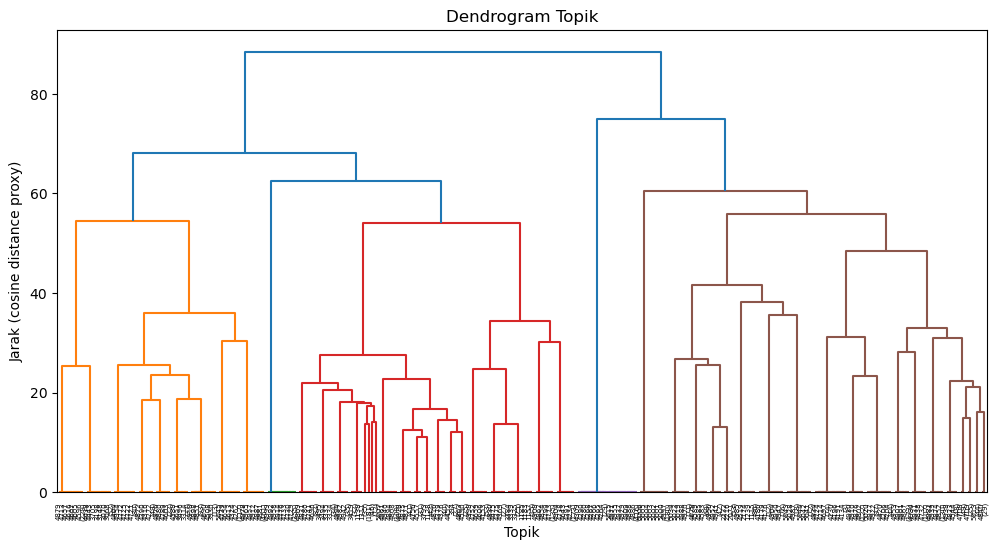

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(embeddings, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=10)  
plt.title("Dendrogram Topik")
plt.xlabel("Topik")
plt.ylabel("Jarak (cosine distance proxy)")
plt.show()


In [ ]:
from collections import defaultdict

clusters = defaultdict(list)

for topic, cluster in zip(df["Topic"], df["merged_cluster"]):
    clusters[cluster].append(topic)

for c, topics in clusters.items():
    print(f"Cluster {c}: {sorted(set(topics))} (jumlah topic: {len(set(topics))})")

print("\n--- Ringkasan ---")
print(f"Total cluster: {len(clusters)}")

largest_cluster = max(clusters.items(), key=lambda x: len(set(x[1])))
smallest_cluster = min(clusters.items(), key=lambda x: len(set(x[1])))

print(f"Cluster terbesar: {largest_cluster[0]} dengan {len(set(largest_cluster[1]))} topic")
print(f"Cluster terkecil: {smallest_cluster[0]} dengan {len(set(smallest_cluster[1]))} topic")


Cluster 9: [0, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 20, 28, 29, 34, 38, 51, 54] (jumlah topic: 18)
Cluster 6: [3, 19, 23] (jumlah topic: 3)
Cluster 8: [1, 11, 21, 22, 25, 33, 47] (jumlah topic: 7)
Cluster 11: [18, 26, 31, 32, 35, 36, 37, 39, 40, 41, 43, 44, 45, 48, 49, 50, 52] (jumlah topic: 17)
Cluster 2: [24, 30, 46] (jumlah topic: 3)
Cluster 10: [42] (jumlah topic: 1)
Cluster 3: [17] (jumlah topic: 1)
Cluster 5: [16] (jumlah topic: 1)
Cluster 4: [15] (jumlah topic: 1)
Cluster 7: [27, 53] (jumlah topic: 2)
Cluster 1: [2] (jumlah topic: 1)

--- Ringkasan ---
Total cluster: 11
Cluster terbesar: 9 dengan 18 topic
Cluster terkecil: 10 dengan 1 topic


## Penggabungan Cluster

In [70]:
import pandas as pd
df_mix = pd.read_csv("KP_tanpaoutlier_new.csv", sep=";")

topic_to_cluster = {
    0: "Cluster 9", 4: "Cluster 9", 5: "Cluster 9", 6: "Cluster 9", 7: "Cluster 9",
    8: "Cluster 9", 9: "Cluster 9", 10: "Cluster 9", 12: "Cluster 9", 13: "Cluster 9",
    14: "Cluster 9", 20: "Cluster 9", 28: "Cluster 9", 29: "Cluster 9", 34: "Cluster 9",
    38: "Cluster 9", 51: "Cluster 9", 54: "Cluster 9",

    3: "Cluster 6", 19: "Cluster 6", 23: "Cluster 6",

    1: "Cluster 8", 11: "Cluster 8", 21: "Cluster 8", 22: "Cluster 8",
    25: "Cluster 8", 33: "Cluster 8", 47: "Cluster 8",

    18: "Cluster 11", 26: "Cluster 11", 31: "Cluster 11", 32: "Cluster 11",
    35: "Cluster 11", 36: "Cluster 11", 37: "Cluster 11", 39: "Cluster 11",
    40: "Cluster 11", 41: "Cluster 11", 43: "Cluster 11", 44: "Cluster 11",
    45: "Cluster 11", 48: "Cluster 11", 49: "Cluster 11", 50: "Cluster 11",
    52: "Cluster 11",

    24: "Cluster 2", 30: "Cluster 2", 46: "Cluster 2",

    42: "Cluster 10",

    17: "Cluster 3",
    16: "Cluster 5",
    15: "Cluster 4",

    27: "Cluster 7", 53: "Cluster 7",

    2: "Cluster 1"
}

# Tambah kolom baru 'Cluster' berdasarkan mapping
df_mix['Cluster'] = df_mix['Topic'].map(topic_to_cluster)

# Cek hasil
print(df_mix.head())


                                            question  \
0  Aku suka minum alkohol biar rileks, apa itu ar...   
1  Saya merasa bersalah karena sering marah ke an...   
2  Aku merasa otakku lelet buat mengingat pelajar...   
3  Aku takut psikolog nggak ngerti budayaku. Apa ...   
4  Saya sering bermimpi, tapi tidak tahu artinya....   

                                              answer  Topic  \
0  Minum alkohol untuk rileks nggak langsung bera...      7   
1  Hai, rasa bersalah itu tanda kamu peduli bange...     19   
2  Belajar itu memang kadang terasa berat, tapi k...      5   
3  Aku ngerti kamu pengen dipahami sesuai budayam...     22   
4  Mimpi itu seperti petunjuk dari batinmu—seru b...     44   

                                      Representation  Probability  \
0  ['mental', 'laku', 'situasi', 'kadang', 'bilan...     0.858497   
1  ['mindset', 'sifat', 'pengaruh', 'sendiri', 'p...     0.935776   
2  ['latih', 'susah', 'sulit', 'jangka', 'distrak...     1.000000   
3  ['psy

In [71]:
df_mix.to_csv("KP_tanpaoutliernew_11fix.csv", index=False, sep=";", encoding="utf-8-sig", quoting=csv.QUOTE_ALL)

In [ ]:
import pandas as pd

df = pd.read_csv(
    r"C:\Users\Liza\Documents\emilia\topic model\new_KPL12_25_7500.csv",
    sep=None,             
    engine='python',      
)
print(df.head())
print(df.columns)

                                           ﻿question  \
0  Bagaimana cara berhenti menyalahkan diri sendi...   
1  Kenapa, ya, aku jadi menjauh dari teman setela...   
2   Seperti apa contoh permintaan maaf yang efektif?   
3  Kenapa aku perlu memaafkan diriku sebelum oran...   
4  Langkah pertama menata ulang hidup setelah kes...   

                                              answer  \
0  Mulailah memetakan fakta: apa yang benar-benar...   
1  Perasaan bersalah yang belum diproses menimbul...   
2  Pertama, rangkum inti peristiwa: "Aku sadar ke...   
3  Self-forgiveness memutus siklus rasa bersalah ...   
4  Mulailah dari hal simpel: tidur cukup, rutinit...   

                                            Document  Topic  \
0  q bagaimana cara henti salah diri sendiri atas...     -1   
1  q aku jadi jauh teman laku salah a asa salah p...     -1   
2  q apa contoh minta maaf efektif a pertama rang...     -1   
3  q aku perlu maaf diri orang a self-forgiveness...     50   
4  q langka

In [11]:
import pandas as pd

df = pd.read_csv(
    r"C:\Users\Liza\Documents\emilia\topic model\new_KPL12_25_7500.csv",
    encoding='utf-8-sig',
    sep=';'
)



df_filtered = df[
    (df['Topic'] != -1) & (df['Representative_document'] == True)
][['Topic', 'Top_n_words', 'question', 'answer', 'Representative_document']]

df_filtered


,Topic,Top_n_words,question,answer,Representative_document
167,50,suportif - minta - gimana - ngerasa - buat - t...,Aku merasa bersalah banget atas sesuatu yang u...,"Rasa bersalah bisa terasa berat, kayak beban y...",True
280,42,bagaimana - bilang - diri - tulis - eksekusi -...,Saya merasa sering gagal karena tujuan saya te...,Kamu bijak menyadari ini—itu langkah menuju ke...,True
426,42,bagaimana - bilang - diri - tulis - eksekusi -...,"Saya ingin maju, tapi merasa terhambat. Apa ya...",Keinginan untuk maju menunjukkan semangat besa...,True
440,44,emosi - bilang - tenang - tulis - kadang - dir...,Saya punya mimpi aneh yang sangat kuat. Apa ar...,Mimpi kuat itu seperti surat dari dalam diri—m...,True
443,40,bagaimana - bilang - saran - tulis - diri - ka...,Saya merasa hidup saya kurang lengkap. Bagaima...,"Rasa ‘kurang’ itu tanda kamu mencari lebih, da...",True
...,...,...,...,...,...
7291,26,laku - bikin - misal - ngomongin - diri - kena...,Aku nggak bisa berhenti mikirin kesalahan masa...,Masa lalu bisa jadi beban berat. Coba tulis ap...,True
7324,26,laku - bikin - misal - ngomongin - diri - kena...,Aku merasa nggak bisa lepas dari kesalahan mas...,"Kesalahan masa lalu itu kayak bayangan, keliha...",True
7346,45,meski - ngerasa - biar - gimana - sempat - bua...,Aku ngerasa dunia nggak adil. Kenapa aku yang ...,Perasaan itu bisa bikin kita stuck. Dunia kada...,True
7377,43,gimana - tanyain - biar - buat - ngontrol - bi...,"Aku nggak suka kalau orang bilang aku salah, k...",Nggak suka dikritik sering datang dari ego yan...,True
